# Modeling Coverage for Neural Machine Translation Note

Various NMT models
+ Encoder-decoder model (Cho et al. 2015EMNLP, Sutskever et al., 2015NIPS)
+ Soft attention model (Bahdanau et al. 2016)  
  - this model searches for a set of positions in a source sentence where the most relevant information is concentrated. The model then predicts a target word based on the context vectors associated
    with these source positions and all the previously generated words.
+ <font color='blue'>Coverage attention model</font> (Tu et al., 2016ACL)
  - this model aims at two common problems in the soft attention model: items in the source words are translated more than twice (over-translation) and not translated (under-translation)
+ Global attention model (Luong et al., 2015EMNLP)
  - this model discards the constraint of online decision making from left-to-right but seeks the most efficient alignment
    in batch manner. A local attention model uses the fixed window size.
+ Context gate model (Tu et al., 2016arxiv)
  - this model focuses on the adequacy of translation which aims at controlling the source context by the gate.
+ Backtranslation model (Sennrich et al., 2016ACL)
  - this model utilizes the additional target side corpus to augment the number of synthetic source sentences.
+ VAE NMT model (Zhang et al., 2016EMNLP)
  - This model deploys a variational autoencoder in NMT: it introduces a continuous latent variable to model the underlying semantics of sentence pairs which enables the generation of a sentence.

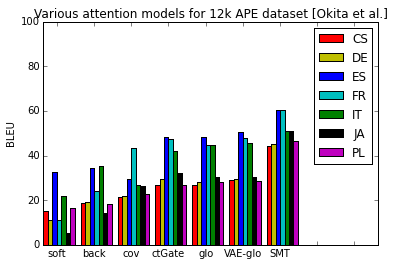

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 9
CS= (15.2,18.6,21.4,27,27,29.1,44.4,0,0)
DE= (10.9,19.3,21.9,29.5,28.2,29.3,45.2,0,0)
ES=(32.7,34.4,29.4,48.3,48.3,50.5,60.2,0,0)
FR=(11.3,24.2,43.5,47.5,44.8,48.0,60.4,0,0)
IT=(21.8,35.4,26.6,41.9,44.6,45.7,50.8,0,0)
JA=(5.5,14.4,26.5,32,30.6,30.6,50.8,0,0)
PL=(16.5,18.3,22.8,26.9,28.2,28.6,46.5,0,0)
ind = np.arange(N)
width = 0.12    

fig, ax = plt.subplots()
rects1 = ax.bar(ind, CS, width, color='r')
rects2 = ax.bar(ind + width, DE, width, color='y')
rects3 = ax.bar(ind + 2*width, ES, width, color='b')
rects4 = ax.bar(ind + 3*width, FR, width, color='c')
rects5 = ax.bar(ind + 4*width, IT, width, color='g')
rects6 = ax.bar(ind + 5*width, JA, width, color='k')
rects7 = ax.bar(ind + 6*width, PL, width, color='m')

ax.set_ylabel('BLEU')
ax.set_title('Various attention models for 12k APE dataset [Okita et al.]')
ax.set_xticks(ind + width*3)
ax.set_xticklabels(('soft', 'back', 'cov', 'ctGate', 'glo', 'VAE-glo', 'SMT'))
ax.set_ylim(0,100)
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0], rects6[0], rects7[0]), 
          ('CS', 'DE', 'ES','FR','IT','JA','PL'))

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()

autolabel(rects1)
autolabel(rects2)

plt.show()

Post-editing example (French->English->English)
+ src:    chute des actions en Asie
+ MT output: fall of actions in Asia
+ Post-edit: fall of shares in Asia

## Coverage Attention Model

Problems of NMT
* Overtranslation: some source words are translated repeatedly.
* Under-translation: some words are untranslated.
    
Solution by NMT-Coverage
* coverage mechanism
  - tracking of the attention history (coverage vector)
  - a source word that has significantly contributed to the generation of target words in the past should be assigned lower alignment probabilities. (Each target word is generated from weighted average of all source words.)
    
Evaluation
* translation quality
* alignment quality

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


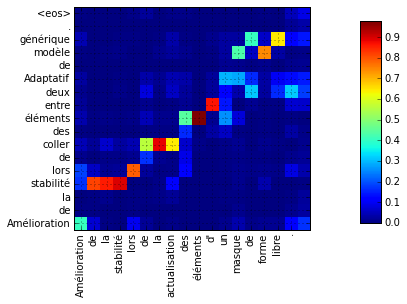

In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import pylab
import numpy
import numpy as np
import matplotlib.pyplot as plt
import os
import pylab

input=u"Amélioration de la stabilité lors de coller des éléments entre deux Adaptatif de modèle générique . <eos>"
output=u"Amélioration de la stabilité lors de la actualisation des éléments d' un masque de forme libre ."
align=[[0.40689149498939514, 0.07174781709909439, 0.004529824014753103, 0.0018213004805147648, 0.09848577529191971, 0.019801219925284386, 0.0009501212043687701, 0.007930392399430275, 0.0033591948449611664, 0.0005109058693051338, 0.0031701819971203804, 0.014869006350636482, 0.03997517749667168, 0.008312276564538479, 0.01647428423166275, 0.019044307991862297, 0.12205513566732407, 0.17021700739860535], [0.005232794675976038, 0.005676566623151302, 0.00030964671168476343, 0.0004553945909719914, 0.004568969830870628, 0.002217139583081007, 0.0007661797571927309, 0.0006493405089713633, 0.0005983790615573525, 0.00010465770901646465, 0.00012809033796656877, 0.0013534827157855034, 0.011545978486537933, 0.0007934417226351798, 0.0023588002659380436, 0.0006509418017230928, 0.012087197974324226, 0.027960816398262978], [0.0022552860900759697, 0.005898299627006054, 0.011876647360622883, 0.0004105422704014927, 0.005066090263426304, 0.004943956155329943, 0.009563378989696503, 0.0196410920470953, 0.0007894439622759819, 0.00031840254087001085, 0.00024216897145379335, 0.004073928575962782, 0.007046017795801163, 0.0008562981965951622, 0.0025784492027014494, 0.0014604834141209722, 0.0068129077553749084, 0.026051221415400505], [0.16848638653755188, 0.8196720480918884, 0.8609678745269775, 0.9000112414360046, 0.003445014590397477, 0.003047109115868807, 0.0087441960349679, 0.10807187110185623, 0.0017145476303994656, 0.0007108692079782486, 7.660493429284543e-05, 0.0019879962783306837, 0.013223044574260712, 0.0008914211648516357, 0.039639707654714584, 0.001753233722411096, 0.0007314372924156487, 0.004630540497601032], [0.1858447939157486, 0.05860814452171326, 0.01755688339471817, 0.021495364606380463, 0.7925500273704529, 0.023371854797005653, 0.004348754417151213, 0.009673407301306725, 0.12132274359464645, 0.0012911054072901607, 0.0016067392425611615, 0.005246450658887625, 0.014453478157520294, 0.009278347715735435, 0.013635704293847084, 0.010875196196138859, 0.08557120710611343, 0.04019179195165634], [0.015215309336781502, 0.0037366379983723164, 0.008434567600488663, 0.0076743182726204395, 0.017660439014434814, 0.1712336391210556, 0.0164016243070364, 0.008845626376569271, 0.0902944952249527, 0.0028795176185667515, 0.000503937597386539, 0.0040257214568555355, 0.008020985871553421, 0.0051873829215765, 0.004319935105741024, 0.0011693865526467562, 0.012039425782859325, 0.01976991631090641], [0.04822971299290657, 0.019297942519187927, 0.06546206772327423, 0.02890421636402607, 0.044212259352207184, 0.561775803565979, 0.8865526914596558, 0.6449522972106934, 0.06875144690275192, 0.010648563504219055, 0.0021032853983342648, 0.00908413715660572, 0.016308175399899483, 0.0036248075775802135, 0.01299147866666317, 0.005102074705064297, 0.0023967712186276913, 0.011925740167498589], [0.007250961381942034, 0.0007135789492167532, 0.002185699064284563, 0.0019076036987826228, 0.0017699935706332326, 0.00682535395026207, 0.00677024619653821, 0.005058369133621454, 0.16218829154968262, 0.0005017853109166026, 0.031100766733288765, 0.05749986693263054, 0.007085626479238272, 0.00339211686514318, 0.005525065585970879, 0.0014130484778434038, 0.03413676470518112, 0.008456194773316383], [0.03843660652637482, 0.006538928486406803, 0.010084589943289757, 0.004259738605469465, 0.008458678610622883, 0.04700373485684395, 0.01308613270521164, 0.012004539370536804, 0.44335585832595825, 0.9775447249412537, 0.01685476489365101, 0.26138409972190857, 0.07753418385982513, 0.0027897097170352936, 0.004871674347668886, 0.0028503017965704203, 0.00449917558580637, 0.0032573631033301353], [0.021090075373649597, 0.0006049344083294272, 0.0017457481008023024, 0.0007266324828378856, 0.0028758859261870384, 0.014171982184052467, 0.0029190867207944393, 0.007396769244223833, 0.015982050448656082, 0.001046250225044787, 0.869610607624054, 0.14298319816589355, 0.002835698425769806, 0.01670415699481964, 0.006695224903523922, 0.005520903039723635, 0.069464311003685, 0.06642963737249374], [0.014297625049948692, 0.002671722089871764, 0.0037444233894348145, 0.008914412930607796, 0.003032415173947811, 0.08123821765184402, 0.009293867275118828, 0.06050857529044151, 0.025441810488700867, 0.00107740075327456, 0.02629445306956768, 0.12068874388933182, 0.04116827994585037, 0.3133434057235718, 0.029650313779711723, 0.16309380531311035, 0.31806087493896484, 0.17956359684467316], [0.026929838582873344, 0.001264883321709931, 0.0021907533518970013, 0.006115128751844168, 0.0036151849199086428, 0.03594714775681496, 0.015342926606535912, 0.04255974292755127, 0.03549125790596008, 0.0004523949755821377, 0.025882869958877563, 0.2975907623767853, 0.2839825749397278, 0.1612831950187683, 0.03082042559981346, 0.10157090425491333, 0.1326269805431366, 0.14617310464382172], [0.002062753075733781, 0.0001154077472165227, 0.0007050393032841384, 0.0008686456712894142, 0.0002392807073192671, 0.00039060672861523926, 0.0007134956540539861, 0.0027730055153369904, 0.002490608487278223, 0.00017504383868072182, 0.003167614573612809, 0.018192971125245094, 0.014939255081117153, 0.007102198898792267, 0.01423715241253376, 0.00379186007194221, 0.012160043232142925, 0.018505021929740906], [0.006646682973951101, 0.00021833869686815888, 0.007245020009577274, 0.008512075059115887, 0.0007576462812721729, 0.001560588483698666, 0.015231558121740818, 0.024055294692516327, 0.012742547318339348, 0.0012794695794582367, 0.006468034349381924, 0.028225133195519447, 0.4315166473388672, 0.05807599425315857, 0.7480894923210144, 0.03292876482009888, 0.005410570185631514, 0.00797372218221426], [0.04374324530363083, 0.0006681405939161777, 0.0022380072623491287, 0.0060243080370128155, 0.004374588839709759, 0.002992879832163453, 0.006537019740790129, 0.037690743803977966, 0.005305823870003223, 0.0006459391443058848, 0.01210412010550499, 0.030182749032974243, 0.026768790557980537, 0.40600481629371643, 0.06402440369129181, 0.6464815139770508, 0.11141415685415268, 0.1448269635438919], [0.0011527874739840627, 6.039993968443014e-05, 5.7023422414204106e-05, 0.00013509950076695532, 0.00018510220979806036, 0.00017297087470069528, 9.898610733216628e-05, 0.0003028903156518936, 0.0001413189893355593, 2.110464447468985e-05, 0.0002532297803554684, 0.0006009016651660204, 0.0007218087557703257, 0.0008249347447417676, 0.00017269427189603448, 0.0015212238067761064, 0.020240576937794685, 0.035734329372644424], [0.006233729887753725, 0.00250613153912127, 0.0006662388332188129, 0.0017639254219830036, 0.008702688850462437, 0.023305872455239296, 0.00267985463142395, 0.007886114530265331, 0.010030214674770832, 0.0007917306502349675, 0.00043252017349004745, 0.0020106590818613768, 0.0028743173461407423, 0.001535496092401445, 0.00391530292108655, 0.0007721011061221361, 0.05029258131980896, 0.08833310753107071]]


def plotAlignmentMatrix(input,output,align):
    input=input.split(' ')
    output=output.split(' ')
    align=numpy.array(align)

    fig, ax = plt.subplots(1,1)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#    im = ax.imshow(align, interpolation='bilinear', origin='lower')
    im = ax.imshow(align, interpolation='nearest', origin='lower')
    outLen=range(len(output))
    inLen=range(len(input))

    ax.grid(True)
    ax.set_xticks(outLen)
    ax.set_yticks(inLen)
    ax.set_xticklabels(output, rotation=90)
    ax.set_yticklabels(input)
    fig.colorbar(im, cax=cbar_ax)
    
plotAlignmentMatrix(input,output,align)

## Coverage model
+ linguistic coverage model (coverage model obeys the rule): $C_{i,j} = C_{i-1,j} + \frac{1}{\Phi_j} \alpha_{i,j}$
+ NN-based model (coverage model is learned from data): $C_{i,j} = f(C_{i-1,j},\alpha_{i,j},h_j,t_{i-1})$

### Linguistic coverage model


In [3]:
from IPython.display import Image
Image(url="coverage.gif")

Equation 7
+ $\Phi=1$ (Xu et al., 2015) (each $\Phi$ is 1) <-> $\Phi_j = \sum_{i=1}^I \alpha_{i,j}$ ($\Phi$ is horizontal sum of $\alpha$)
+ unnormalized (Cohn et al., 2016)
+ $\Phi$ can be predicted by the concept of fertility.
(Fertility: Fertility of source word $x_j$ tells how many target words $x_j$ produces.)

![title](./st5-4.jpg "ShowMyImage")

![title](./st4-3.jpg "ShowMyImage")

### SMT (beam search algorithm contains coverage vector as a guide)

![title](./smt.jpg "ShowMyImage")

![title](./smt2.jpg "ShowMyImage")

### 3.1.2 Neural network-based coverage model
+ $C_{i,j} = f(C_{i-1,j},\alpha_{i,j},h_j,t_{i-1})$
+ In practice, they modified the conditional GRU decoder by
  - $e_{i,j} = a(t_{i-1}, h_j, C_{i-1,j}) = v_a^T \mbox{tanh} (W_at_{i-1}+U_a h_j +V_a C_{i-1,j})$

# Training
+ Optimization with ($\theta$, $\eta$): $\eta$ is the parameters for coverage models.
  - combined objective: consistently making it worse for translation quality. (equation including penalization term; middle of p81)
  - the objective associated with the translation quality (i.e. likelihood) to drive the training (equation 9)

# Experiments
+ 5.2 Translation quality
  - linguistic coverage model
    * the simplest linguistic coverage model was already siginicantly better.
    * fertility made it better
  - NN-based model
    * 0.8, 1.3 BLEU points better than Groundhog.
    * coverage dimension 10 was better than coverage dimension 1.
+ 5.3 Alignment quality
  - linguistic coverage model
    * fertility reduces alignment errors
  - NN-based model
    * only the coverage dimension 10 reduced the alignment errors
    * the coverage dimension 1 did not reduce the alignment errors

+ 5.4 Effects on long sentences
  - Groundhog produces much shorter translations on longer sentences (this would be the under-translation problem)
  - Coverage model discourages the early stop
  - NN-based and linguistic coverage models perform similarly on long sentences.
    

In [4]:
def plotAlignmentMatrix2(align):
    #input=input.split(' ')
    #output=output.split(' ')
    align=numpy.array(align)

    fig, ax = plt.subplots(1,1)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#    im = ax.imshow(align, interpolation='bilinear', origin='lower')
    im = ax.imshow(align, interpolation='nearest', origin='lower')
    #outLen=range(len(output))
    #inLen=range(len(input))

    ax.grid(True)
    #ax.set_xticks(outLen)
    #ax.set_yticks(inLen)
    #ax.set_xticklabels(output, rotation=90)
    #ax.set_yticklabels(input)
    fig.colorbar(im, cax=cbar_ax)

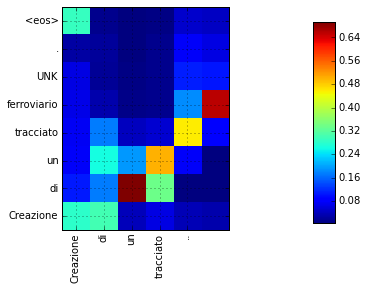

In [24]:
input = 'Creazione di un tracciato ferroviario UNK . <eos>'
output='Creazione di un tracciato ..'
align=[[0.28414276242256165, 0.3007628619670868, 0.03994550183415413, 0.0643320307135582, 0.03630470484495163, 0.032609645277261734], 
       [0.10806899517774582, 0.1760103702545166, 0.6945845484733582, 0.3360172212123871, 0.004785218276083469, 0.004962910432368517], 
       [0.07927659153938293, 0.262908011674881, 0.19342610239982605, 0.500490128993988, 0.07825153321027756, 0.003914442379027605], 
       [0.07660869508981705, 0.17421582341194153, 0.04282122105360031, 0.053927622735500336, 0.45721858739852905, 0.08511614799499512], 
       [0.06847814470529556, 0.03319770470261574, 0.010782917961478233, 0.013001966290175915, 0.18475167453289032, 0.6585834622383118], 
       [0.06508899480104446, 0.019240034744143486, 0.008588030934333801, 0.012039316818118095, 0.11103465408086777, 0.10459951311349869], 
       [0.026851985603570938, 0.021128123626112938, 0.0060564856976270676, 0.012760904617607594, 0.07682894170284271, 0.06507141888141632], 
       [0.29148387908935547, 0.012537077069282532, 0.0037951976992189884, 0.0074307965114712715, 0.05082465335726738, 0.04514244198799133]]
cov='Creazione/0.76 di/1.32 un/1.12 tracciato/0.89 ferroviario/0.97 UNK/0.32 ./0.21 <eos>/0.41'

plotAlignmentMatrix(input,output,align)

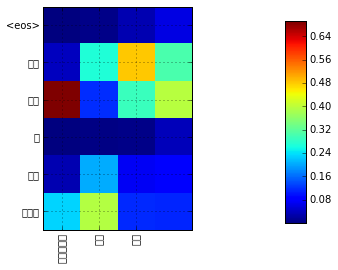

In [23]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
input=u"プラグ イン の 開発 環境 <eos>"
output=u"プラグイン 開発 環境"
align=[[0.23051343858242035, 0.3935387432575226, 0.11463367193937302, 0.11263027042150497], [0.031552527099847794, 0.20583592355251312, 0.07177898287773132, 0.08663345128297806], [0.001033772132359445, 0.004231580067425966, 0.007045750971883535, 0.03831290081143379], [0.6921325922012329, 0.11718098074197769, 0.2918573021888733, 0.3965752422809601], [0.041504476219415665, 0.27092891931533813, 0.48166146874427795, 0.3034937381744385], [0.003263171063736081, 0.008283858187496662, 0.033022843301296234, 0.062354378402233124]]
cov='プラグ/0.85 イン/0.40 の/0.05 開発/1.50 環境/1.10 <eos>/0.11'
plotAlignmentMatrix(input,output,align)

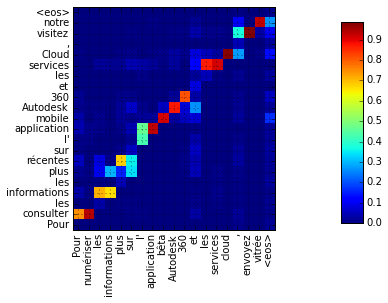

In [7]:
input=u"Pour consulter les informations les plus récentes sur l' application mobile Autodesk 360 et les services Cloud , visitez notre <eos>"
output=u"Pour numériser les informations plus sur l' application bêta Autodesk 360 et les services cloud , envoyez vitrée <eos>"
align=[[0.0027973009273409843, 0.00044632889330387115, 0.0009973073611035943, 3.3250940759899095e-05, 0.002738382201641798, 0.0016870303079485893, 0.0004914150922559202, 2.5236209694412537e-05, 0.0002263101632706821, 0.000522012182045728, 0.0018923424649983644, 0.0015674462774768472, 0.0009555538999848068, 0.001329683931544423, 0.0011405068216845393, 0.01303905714303255, 0.00229608453810215, 0.001523420913144946, 0.01999511942267418], [0.7454723119735718, 0.9413918256759644, 0.0014620341826230288, 8.26358373160474e-05, 0.001234832569025457, 0.005215287208557129, 0.006034208461642265, 0.0016526889521628618, 9.483678149990737e-05, 0.0006326352595351636, 0.00131218321621418, 0.0309815164655447, 0.0010232579661533237, 0.0033659087494015694, 0.0004419269098434597, 0.02135804481804371, 0.0010046737734228373, 0.00039987429045140743, 0.008479868993163109], [0.002036881633102894, 0.0015000022249296308, 0.03776705265045166, 0.0009307629661634564, 0.0050224619917571545, 0.003962196875363588, 0.0029867312405258417, 0.0004240984853822738, 0.0002000681997742504, 0.002484368858858943, 0.0015490149380639195, 0.011558479629456997, 0.0011121303541585803, 0.005537592340260744, 0.0003890985972248018, 0.003906496800482273, 0.00023032845638226718, 0.0019342901650816202, 0.016089269891381264], [0.03726586326956749, 0.0073181455954909325, 0.7143041491508484, 0.6652588248252869, 0.0029676409903913736, 0.003381787333637476, 0.0022809260990470648, 0.0010181843535974622, 0.00037339344271458685, 0.0005960333510302007, 0.0007035053567960858, 0.004537899047136307, 0.0006083112675696611, 0.01295379176735878, 0.00026115673244930804, 0.004366395063698292, 0.00018890525097958744, 0.0015543331392109394, 0.00863733608275652], [0.0014396222541108727, 0.00016835627320688218, 0.004700694233179092, 0.0010375006822869182, 0.04768766835331917, 0.0013443086063489318, 0.00047000846825540066, 5.53703612240497e-05, 0.00011579937563510612, 0.0003432455996517092, 0.00273366691544652, 0.0016935686580836773, 0.00038435275200754404, 0.005338778253644705, 0.0002719871699810028, 0.00430919136852026, 0.0004952226299792528, 0.0022817756980657578, 0.025530992075800896], [0.01760510355234146, 0.004022418987005949, 0.10035863518714905, 0.29805073142051697, 0.15557415783405304, 0.34294599294662476, 0.003816842334344983, 0.0009993434650823474, 0.0007524474058300257, 0.002463615033775568, 0.006845817435532808, 0.04822717234492302, 0.0013755441177636385, 0.008664933033287525, 0.0005990166100673378, 0.009312537498772144, 0.0009092139662243426, 0.0029249752406030893, 0.016574395820498466], [0.055298589169979095, 0.00260363076813519, 0.08279585093259811, 0.007789437659084797, 0.6806130409240723, 0.3583586812019348, 0.0034298733808100224, 0.0006033687386661768, 0.0018324097618460655, 0.0017048693262040615, 0.010764813981950283, 0.041046950966119766, 0.0006152043351903558, 0.0036096088588237762, 0.0014119647676125169, 0.029179485514760017, 0.001156151876784861, 0.0037998727057129145, 0.021423684433102608], [0.004385925363749266, 0.002400403143838048, 0.001234154449775815, 8.880170207703486e-05, 0.010914516635239124, 0.06103520095348358, 0.0013153785839676857, 0.00019628308655228466, 0.00022479851031675935, 0.0010887073585763574, 0.004710040986537933, 0.060473013669252396, 0.0003674532053992152, 0.001153531949967146, 0.0004966060514561832, 0.01956823468208313, 0.0007307811756618321, 0.00043290937901474535, 0.030615005642175674], [0.009101293981075287, 0.009444724768400192, 0.0017153231892734766, 0.00019745758618228137, 0.0019166204147040844, 0.015507747419178486, 0.42965617775917053, 0.00202321819961071, 0.0005435882485471666, 0.002300526713952422, 0.001902522868476808, 0.03844986483454704, 0.00023046457499731332, 0.00014383488451130688, 0.00011514651851030067, 0.009448414668440819, 0.0003561645280569792, 0.0002692046109586954, 0.02105618081986904], [0.044208478182554245, 0.011656134389340878, 0.010333335027098656, 0.0022315962705761194, 0.008095680736005306, 0.04631184786558151, 0.46433964371681213, 0.9313916563987732, 0.001494225230999291, 0.000768462719861418, 0.000692036293912679, 0.006248865742236376, 0.00023285353381652385, 0.0010825429344549775, 0.00012419058475643396, 0.002255401574075222, 6.316373037407175e-05, 0.0015892308438196778, 0.020419668406248093], [0.03593174368143082, 0.0022563873790204525, 0.01180192455649376, 0.0007772656390443444, 0.022829104214906693, 0.014684981666505337, 0.02004288323223591, 0.02357008494436741, 0.9150961637496948, 0.03019157238304615, 0.05503881722688675, 0.07631122320890427, 0.0007424835930578411, 0.0008648210787214339, 0.0029743826016783714, 0.02582329697906971, 0.0007176513317972422, 0.006452773232012987, 0.16988559067249298], [0.01298863161355257, 0.005135037004947662, 0.006273126229643822, 0.00027596025029197335, 0.019616493955254555, 0.06498950719833374, 0.014540839940309525, 0.0013319352874532342, 0.0611485056579113, 0.8746737837791443, 0.07353664934635162, 0.26613515615463257, 0.001438524341210723, 0.0005422838730737567, 0.0005714903236366808, 0.017454655840992928, 0.0003134222060907632, 0.0009057651623152196, 0.020648641511797905], [0.016150733456015587, 0.0020216561388224363, 0.00037558472831733525, 6.887882045703009e-05, 0.010149793699383736, 0.010222382843494415, 0.0016740370774641633, 0.00024395628133788705, 0.002530793659389019, 0.02224123477935791, 0.8116443753242493, 0.038166217505931854, 3.7376674299594015e-05, 0.000321848870953545, 0.0002734558656811714, 0.013236526399850845, 0.00025438665761612356, 0.0016231199260801077, 0.055569685995578766], [0.0007080601062625647, 0.00010833272972377017, 4.5770881115458906e-05, 2.4384860807913356e-05, 0.0008094031945802271, 0.003150295466184616, 0.00024718366330489516, 3.7757225072709844e-05, 1.5313575204345398e-05, 0.0002495864755474031, 0.0010885664960369468, 0.08432894945144653, 0.00011266925139352679, 0.00010034860315499827, 8.714754949323833e-05, 0.00149285770021379, 4.774915214511566e-05, 0.00020083945128135383, 0.0019388345535844564], [0.001510445261374116, 0.0009051965898834169, 0.0005606599734164774, 0.000403037469368428, 0.000968068081419915, 0.00385319534689188, 0.008761812932789326, 0.0003218119964003563, 9.842185681918636e-05, 0.00216622743755579, 0.0005310802953317761, 0.025642210617661476, 0.05388485640287399, 0.004042485263198614, 0.0002221544273197651, 0.01658065989613533, 0.00028013091650791466, 0.0014907274162396789, 0.024703288450837135], [0.00373144936747849, 0.0029620982240885496, 0.02315419353544712, 0.018694685772061348, 0.01828073151409626, 0.04516591876745224, 0.033195268362760544, 0.02279539778828621, 0.005319175776094198, 0.0235552079975605, 0.003819806268438697, 0.1254291981458664, 0.8691385388374329, 0.9116869568824768, 0.0012469151988625526, 0.0015783854760229588, 9.438072447665036e-05, 0.000754628679715097, 0.003254274372011423], [0.004082823172211647, 0.0012797437375411391, 0.001735767931677401, 0.0031814291141927242, 0.0075998264364898205, 0.008443832397460938, 0.0032198806293308735, 0.005202135071158409, 0.008501685224473476, 0.027356455102562904, 0.012142408639192581, 0.07809656113386154, 0.053865496069192886, 0.02914341911673546, 0.9789191484451294, 0.27545681595802307, 0.0010294204112142324, 0.009498762898147106, 0.13282746076583862], [0.00037165189860388637, 0.00025639848900027573, 2.2277183234109543e-05, 8.410193913732655e-06, 0.00014488733722828329, 0.0003204972017556429, 7.500868377974257e-05, 3.198389822500758e-05, 1.0007933269662317e-05, 4.718189302366227e-05, 0.00023761336342431605, 0.0028700297698378563, 2.7218495233682916e-05, 6.59137949696742e-05, 0.00020943446725141257, 0.046569157391786575, 6.257036147871986e-05, 0.0011477965163066983, 0.025117821991443634], [0.003358003217726946, 0.003533862764015794, 0.00011431152961449698, 0.0005698181921616197, 0.0023041157983243465, 0.007031562738120556, 0.00215041427873075, 0.003634548280388117, 0.0007932340377010405, 0.004730522632598877, 0.006873404141515493, 0.03849074989557266, 0.011503301560878754, 0.008962737396359444, 0.007440811954438686, 0.37692269682884216, 0.9884966015815735, 0.030977198854088783, 0.09615049511194229], [0.0014044006820768118, 0.0004830174148082733, 0.0002265352086396888, 0.0002473845088388771, 0.00044738364522345364, 0.00145797582808882, 0.001129242475144565, 0.004390666726976633, 0.0005698768654838204, 0.0015441589057445526, 0.0018885185709223151, 0.018048062920570374, 0.002300569089129567, 0.0010021638590842485, 0.002673528390005231, 0.10058989375829697, 0.001220193225890398, 0.9299955368041992, 0.26698198914527893], [0.00015070718654897064, 0.00010637475497787818, 2.1373249182943255e-05, 4.766690108226612e-05, 8.514044020557776e-05, 0.00092975830193609, 0.0001423038775101304, 5.021088509238325e-05, 5.892527042306028e-05, 0.0003395969106350094, 9.279116784455255e-05, 0.0016969565767794847, 4.38945644418709e-05, 8.68155766511336e-05, 0.00012992430129088461, 0.007551839575171471, 5.2839386626146734e-05, 0.00024294160539284348, 0.014100372791290283]]
plotAlignmentMatrix(input,output,align)

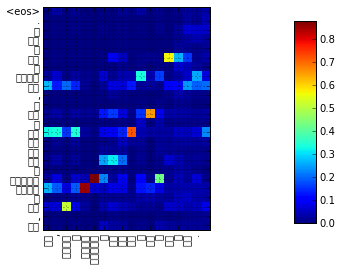

In [8]:
input=u"また , など の ソリッド ジオメトリ が 含ま れて いる 鉄筋 の 要素 は , この フィルタ を 通過 し ませ ん . <eos>"
output=u"また , チューブ の ソリッド ジオメトリ を 使用 した 基礎 の 要素 を 取得 し ます ."
align=[[0.002524938667193055, 0.004497024230659008, 0.003320652525871992, 0.012065377086400986, 0.0009657740592956543, 0.002258402295410633, 0.05216986685991287, 0.025661669671535492, 0.02337498776614666, 0.0022027986124157906, 0.012677631340920925, 0.0038037444464862347, 0.034395962953567505, 0.022744448855519295, 0.018118223175406456, 0.01879720203578472, 0.018471945077180862, 0.014397039078176022], [0.0003029484942089766, 0.001019679824821651, 0.00037937096203677356, 0.00173981674015522, 0.0002495495427865535, 0.0001743689936120063, 0.0015147470403462648, 0.0038645113818347454, 0.0036599936429411173, 0.0004503939126152545, 0.0023849455174058676, 0.0010792085668072104, 0.005773695185780525, 0.002380130346864462, 0.005138058681041002, 0.008728265762329102, 0.01226200070232153, 0.01464306004345417], [0.0583309680223465, 0.06666014343500137, 0.5172069668769836, 0.08141756057739258, 0.021447671577334404, 0.003051565960049629, 0.035985130816698074, 0.05965128913521767, 0.04288323596119881, 0.02985132485628128, 0.01702163740992546, 0.019212011247873306, 0.010167946107685566, 0.05589419603347778, 0.05314577743411064, 0.035909440368413925, 0.043233923614025116, 0.07914377748966217], [0.0013213356724008918, 0.006028252188116312, 0.0038006536196917295, 0.01436156127601862, 0.008282860741019249, 0.001616543740965426, 0.014478305354714394, 0.012821703217923641, 0.016283245757222176, 0.013391941785812378, 0.029662733897566795, 0.03517000377178192, 0.0227586068212986, 0.018768511712551117, 0.046474702656269073, 0.05420607700943947, 0.033359333872795105, 0.029131507501006126], [0.26600000262260437, 0.18985112011432648, 0.07776599377393723, 0.18679863214492798, 0.856597363948822, 0.06804075092077255, 0.04915427416563034, 0.07601014524698257, 0.07882876694202423, 0.012044691480696201, 0.12569206953048706, 0.13963863253593445, 0.07880520075559616, 0.02959360182285309, 0.03455672040581703, 0.03539338335394859, 0.035496339201927185, 0.031359802931547165], [0.023228375241160393, 0.0729471817612648, 0.006202704273164272, 0.06200519576668739, 0.03895952180027962, 0.8779681921005249, 0.22392016649246216, 0.02246883325278759, 0.09123691916465759, 0.0027227469254285097, 0.0993897020816803, 0.016980299726128578, 0.42668673396110535, 0.011435057036578655, 0.04221951961517334, 0.019166884943842888, 0.06620132923126221, 0.011627326719462872], [4.263462687958963e-05, 0.00036602915497496724, 9.634649904910475e-05, 0.0018104418413713574, 3.3234104193979874e-05, 0.00012144936772529036, 0.005449375137686729, 0.005029915366321802, 0.011837245896458626, 0.0013150086160749197, 0.004654855001717806, 0.0005138518172316253, 0.003487011417746544, 0.012773844413459301, 0.027959410101175308, 0.02014486864209175, 0.009231191128492355, 0.0031377109698951244], [0.007107187993824482, 0.030253026634454727, 0.005423197988420725, 0.02081950567662716, 0.002708414802327752, 0.0024409478064626455, 0.25268229842185974, 0.31523290276527405, 0.20434243977069855, 0.003100432688370347, 0.014468302018940449, 0.002125921892002225, 0.008790150284767151, 0.05908053368330002, 0.03791474923491478, 0.015412366949021816, 0.017451683059334755, 0.01180217694491148], [0.00038411162677221, 0.003446045331656933, 0.0019785757176578045, 0.008492826484143734, 0.00025302698486484587, 0.0006285852869041264, 0.021740714088082314, 0.013912088237702847, 0.02718099020421505, 0.0009251420851796865, 0.011569101363420486, 0.001389220473356545, 0.018451988697052002, 0.015776555985212326, 0.014815613627433777, 0.008706542663276196, 0.011793679557740688, 0.00949486717581749], [0.002670474350452423, 0.013811840675771236, 0.005461381748318672, 0.02372300997376442, 0.0007957449415698647, 0.0005424925475381315, 0.010029966942965984, 0.01210808102041483, 0.049547843635082245, 0.020055321976542473, 0.018411854282021523, 0.0025100894272327423, 0.017844747751951218, 0.016860397532582283, 0.02456526644527912, 0.0225193090736866, 0.017733143642544746, 0.025868741795420647], [0.3238663971424103, 0.335712194442749, 0.15611501038074493, 0.3385389447212219, 0.02363845705986023, 0.010991142131388187, 0.0830470398068428, 0.09099826216697693, 0.13769477605819702, 0.7186919450759888, 0.03908148407936096, 0.02877774089574814, 0.0257701575756073, 0.02496510185301304, 0.05276758223772049, 0.04156964272260666, 0.06826751679182053, 0.2277849167585373], [0.0004240329726599157, 0.0020232268143445253, 0.0005870303721167147, 0.0028202214743942022, 0.0007914004963822663, 0.0011115737725049257, 0.006313330493867397, 0.0010487934341654181, 0.0074773323722183704, 0.0031404669862240553, 0.052126117050647736, 0.004756262991577387, 0.031805284321308136, 0.003883550176396966, 0.010821212083101273, 0.009330091066658497, 0.00956337247043848, 0.009907016530632973], [0.014030714519321918, 0.03018205612897873, 0.008401799947023392, 0.028241656720638275, 0.014452665112912655, 0.0194002166390419, 0.12703175842761993, 0.15956519544124603, 0.07264377176761627, 0.011699164286255836, 0.15101756155490875, 0.6529273390769958, 0.08298800140619278, 0.029347792267799377, 0.031460050493478775, 0.026635361835360527, 0.019807150587439537, 0.025934696197509766], [1.2888018318335526e-05, 0.00040457723662257195, 6.42182567389682e-05, 0.001284164609387517, 0.0002718762552831322, 0.00023953820345923305, 0.0014616330154240131, 0.00040681357495486736, 0.005314197391271591, 0.0003722323745023459, 0.0043637873604893684, 0.0003327747108414769, 0.007728979457169771, 0.002720111981034279, 0.015208568423986435, 0.00898299552500248, 0.0033528455533087254, 0.0022874295245856047], [0.00012579404574353248, 0.0021139329764992, 0.0003624743258114904, 0.001059913425706327, 0.0005095662781968713, 0.00024087050405796617, 0.003937858156859875, 0.017521196976304054, 0.013006648048758507, 0.0019535955507308245, 0.002873286372050643, 0.0004926930996589363, 0.00261291372589767, 0.008344922214746475, 0.034864071756601334, 0.020094117149710655, 0.012856160290539265, 0.007837342098355293], [0.26960718631744385, 0.13298703730106354, 0.19898036122322083, 0.1386471837759018, 0.014189106412231922, 0.001524524879641831, 0.02345285378396511, 0.07497046887874603, 0.06868895888328552, 0.1286155730485916, 0.022318005561828613, 0.024120550602674484, 0.011964594945311546, 0.09594308584928513, 0.10815920680761337, 0.24177174270153046, 0.1929110288619995, 0.20455783605575562], [0.023837752640247345, 0.059822969138622284, 0.007289184257388115, 0.030141346156597137, 0.013551170006394386, 0.007924661040306091, 0.06409522891044617, 0.015707533806562424, 0.03948212414979935, 0.03821251913905144, 0.33452340960502625, 0.043489597737789154, 0.16316679120063782, 0.008876628242433071, 0.03268962353467941, 0.05495745316147804, 0.2544257640838623, 0.07544451206922531], [6.268049764912575e-05, 0.0012052905512973666, 3.639112401288003e-05, 0.0016019882168620825, 9.653076267568395e-05, 7.784499030094594e-05, 0.0012580372858792543, 0.001112907542847097, 0.011518851853907108, 0.0007128302240744233, 0.006972907111048698, 0.0006037759012542665, 0.004882482811808586, 0.004305231384932995, 0.06304188072681427, 0.04462941363453865, 0.023675555363297462, 0.00766289746388793], [0.001643317169509828, 0.0063515473157167435, 0.0004784604534506798, 0.004532328806817532, 0.0009700487717054784, 0.00046375792589969933, 0.004737697076052427, 0.08612186461687088, 0.05173460394144058, 0.002183335367590189, 0.00916801206767559, 0.015126621350646019, 0.009473063051700592, 0.5675879716873169, 0.26441577076911926, 0.15549004077911377, 0.015617039985954762, 0.03280950337648392], [9.210374992107973e-05, 0.0005823354003950953, 6.082062827772461e-05, 0.001137407380156219, 5.9913254517596215e-05, 2.860082167899236e-05, 0.0009315151255577803, 0.000733139633666724, 0.00596628338098526, 0.0007912737200967968, 0.002193545224145055, 0.00031820579897612333, 0.002144286874681711, 0.0018598501337692142, 0.022162210196256638, 0.016598522663116455, 0.00920522678643465, 0.016374358907341957], [0.0002717692987062037, 0.001122022862546146, 0.00020155687525402755, 0.0026718575973063707, 5.222149775363505e-05, 4.164829078945331e-05, 0.0016346597112715244, 0.0013238962274044752, 0.0058748601004481316, 0.0007519802311435342, 0.001385436044074595, 0.00033369282027706504, 0.002536467742174864, 0.0020306550431996584, 0.016867680475115776, 0.02687154710292816, 0.038199204951524734, 0.026518873870372772], [0.0013670698972418904, 0.006747659761458635, 0.00045367665006779134, 0.010221566073596478, 0.000188004836672917, 0.0002973908558487892, 0.007360396906733513, 0.0015254797181114554, 0.007681087125092745, 0.0013568563153967261, 0.005244171246886253, 0.0012652784353122115, 0.011667411774396896, 0.0019334706012159586, 0.022798780351877213, 0.06794661283493042, 0.061418063938617706, 0.057581979781389236], [0.000578418665099889, 0.002423394937068224, 0.00029695991543121636, 0.006453974638134241, 0.00011831003212137148, 7.81157286837697e-05, 0.0014314486179500818, 0.00033457446261309087, 0.004703616723418236, 0.0010648940224200487, 0.003266493557021022, 0.0004990558954887092, 0.00491900322958827, 0.0009074581903405488, 0.006193493027240038, 0.022833483293652534, 0.011180447414517403, 0.04047943651676178], [0.0021668775007128716, 0.02944139763712883, 0.005036210175603628, 0.019413556903600693, 0.0008175819530151784, 0.000736850081011653, 0.006181715056300163, 0.0018687412375584245, 0.01903720758855343, 0.004393542651087046, 0.029532987624406815, 0.004533401224762201, 0.01117849163711071, 0.0019868798553943634, 0.013641814701259136, 0.023304594680666924, 0.014286058954894543, 0.034213170409202576]]
plotAlignmentMatrix(input,output,align)

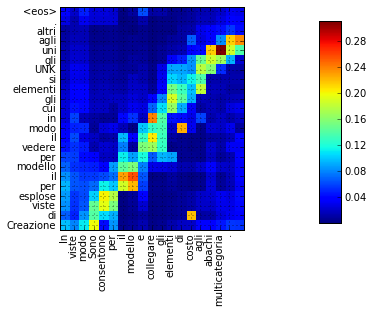

In [9]:
input="Creazione di viste esplose per il modello per vedere il modo in cui gli elementi si UNK gli uni agli altri . <eos>"
output="In viste modo Sono consentono per il modello e collegare gli elementi di costo agli abachi multicategoria ."
align=[[0.09811963140964508, 0.07940119504928589, 0.11149999499320984, 0.1986042708158493, 0.04262784123420715, 0.08417858928442001, 0.004717979580163956, 0.008804403245449066, 0.014751258306205273, 0.004041757900267839, 0.006008012220263481, 0.012744338251650333, 0.01954294741153717, 0.020403552800416946, 0.038971029222011566, 0.039686158299446106, 0.04530580714344978, 0.05571099743247032, 0.05486685410141945], [0.06776045262813568, 0.04897570237517357, 0.08448068797588348, 0.1406368464231491, 0.10621985793113708, 0.09300022572278976, 0.002084564184769988, 0.005210092291235924, 0.009993270970880985, 0.002469092607498169, 0.0036909121554344893, 0.005869021639227867, 0.008587890304625034, 0.2195681482553482, 0.010519590228796005, 0.011937731876969337, 0.025342028588056564, 0.031722292304039, 0.035439420491456985], [0.0836443156003952, 0.054032884538173676, 0.06475914269685745, 0.1468479484319687, 0.19526362419128418, 0.15511180460453033, 0.0022735234815627337, 0.007206002250313759, 0.022329134866595268, 0.0026892838068306446, 0.0038941006641834974, 0.005878985393792391, 0.008764507248997688, 0.012223966419696808, 0.01993364840745926, 0.020911158993840218, 0.03018779121339321, 0.02860458940267563, 0.04136231169104576], [0.08664558082818985, 0.055528003722429276, 0.062021318823099136, 0.10263445973396301, 0.2017432451248169, 0.17673370242118835, 0.0023644522298127413, 0.008265642449259758, 0.03674038499593735, 0.0029509682208299637, 0.003932334017008543, 0.0052422829903662205, 0.008634471334517002, 0.012068904004991055, 0.02082682214677334, 0.022344425320625305, 0.03144126012921333, 0.02719852887094021, 0.04207683727145195], [0.09386632591485977, 0.06587560474872589, 0.0629558190703392, 0.07083415985107422, 0.11382437497377396, 0.09997422248125076, 0.18727821111679077, 0.22207526862621307, 0.05817703902721405, 0.005137251224368811, 0.004572480451315641, 0.007763471454381943, 0.005231473129242659, 0.003678801003843546, 0.005958085414022207, 0.025424333289265633, 0.008298130705952644, 0.015360654331743717, 0.03232648968696594], [0.08367809653282166, 0.06543967872858047, 0.05713224783539772, 0.05736352130770683, 0.06181519851088524, 0.07224435359239578, 0.23019185662269592, 0.25695815682411194, 0.06531771272420883, 0.002873589051887393, 0.0030878609977662563, 0.008965994231402874, 0.004571269266307354, 0.002341223880648613, 0.004954220727086067, 0.02298198826611042, 0.007596961222589016, 0.01711186207830906, 0.03870032727718353], [0.0687662810087204, 0.05405411869287491, 0.05102717503905296, 0.04833042994141579, 0.03577348589897156, 0.08693037182092667, 0.1438605934381485, 0.15626093745231628, 0.07833784073591232, 0.029092079028487206, 0.02792195975780487, 0.024244416505098343, 0.013974848203361034, 0.013289145193994045, 0.02140706405043602, 0.03791167959570885, 0.021283090114593506, 0.02088085561990738, 0.03347116336226463], [0.05873586982488632, 0.057559188455343246, 0.04233008995652199, 0.037135083228349686, 0.0197907667607069, 0.018309039995074272, 0.11200529336929321, 0.08866611868143082, 0.11847243458032608, 0.06692743301391602, 0.09454064816236496, 0.08947648108005524, 0.0061805760487914085, 0.005860485602170229, 0.005126871168613434, 0.01752265729010105, 0.007732137106359005, 0.01445433683693409, 0.040144920349121094], [0.04492456093430519, 0.054409220814704895, 0.04711053520441055, 0.014366820454597473, 0.02291608601808548, 0.020603643730282784, 0.07777103781700134, 0.009573831222951412, 0.15600979328155518, 0.16691234707832336, 0.12831741571426392, 0.003014515619724989, 0.005863426253199577, 0.0035151096526533365, 0.004203530494123697, 0.022213192656636238, 0.013237548992037773, 0.03315845876932144, 0.03313685208559036], [0.038856469094753265, 0.06112034246325493, 0.027528919279575348, 0.019688213244080544, 0.011086688376963139, 0.013046341948211193, 0.09616886079311371, 0.03988930210471153, 0.12802864611148834, 0.20454567670822144, 0.13058140873908997, 0.010075392201542854, 0.004327764268964529, 0.003916333429515362, 0.003381568705663085, 0.009979353286325932, 0.01039308775216341, 0.016616610810160637, 0.036094631999731064], [0.03354313597083092, 0.049022126942873, 0.050340477377176285, 0.007780021522194147, 0.025548582896590233, 0.030509525910019875, 0.016639994457364082, 0.0038247318007051945, 0.09996870160102844, 0.12657664716243744, 0.13391265273094177, 0.020367413759231567, 0.22479969263076782, 0.03121807612478733, 0.005248521454632282, 0.022776972502470016, 0.020950738340616226, 0.02999362163245678, 0.010132284834980965], [0.02515817992389202, 0.05870659276843071, 0.016614487394690514, 0.010347786359488964, 0.007398315239697695, 0.007819077000021935, 0.041435204446315765, 0.05418764427304268, 0.019073642790317535, 0.2393452674150467, 0.13867594301700592, 0.044626351445913315, 0.041711557656526566, 0.029449859634041786, 0.058903470635414124, 0.013134665787220001, 0.018894856795668602, 0.013546457514166832, 0.018876725807785988], [0.025488466024398804, 0.04494018852710724, 0.04093266651034355, 0.01881987228989601, 0.019304698333144188, 0.010753756389021873, 0.020818514749407768, 0.03180292621254921, 0.0273060891777277, 0.06985963881015778, 0.10760799050331116, 0.1645226925611496, 0.0916128158569336, 0.03386286273598671, 0.010444891639053822, 0.016525998711586, 0.01260820496827364, 0.027021300047636032, 0.03008977696299553], [0.023714998736977577, 0.040153924375772476, 0.03743116930127144, 0.016431899741292, 0.017333995550870895, 0.01978672482073307, 0.0178142711520195, 0.025400778278708458, 0.019961312413215637, 0.040184274315834045, 0.07934977114200592, 0.18828023970127106, 0.14223921298980713, 0.09261491894721985, 0.017355071380734444, 0.014739962294697762, 0.011625062674283981, 0.015406806021928787, 0.016240105032920837], [0.02107383869588375, 0.037184134125709534, 0.034962598234415054, 0.014849500730633736, 0.016279088333249092, 0.014485523104667664, 0.011598785407841206, 0.02080852910876274, 0.018832098692655563, 0.00844624824821949, 0.03974807634949684, 0.15203069150447845, 0.13018202781677246, 0.09808099269866943, 0.18036378920078278, 0.017042990773916245, 0.015126435086131096, 0.011271530762314796, 0.011095940135419369], [0.017188921570777893, 0.02968009002506733, 0.028242986649274826, 0.01158361230045557, 0.012623895891010761, 0.011189152486622334, 0.008578166365623474, 0.017897076904773712, 0.012804549187421799, 0.005141792818903923, 0.031762558966875076, 0.10398570448160172, 0.0956866443157196, 0.11319541186094284, 0.1375717669725418, 0.012783920392394066, 0.013588978908956051, 0.012984334491193295, 0.013465412892401218], [0.01788535714149475, 0.030907917767763138, 0.028951529413461685, 0.010998785495758057, 0.012434988282620907, 0.011363607831299305, 0.007341589313000441, 0.008336185477674007, 0.012875022366642952, 0.004317323211580515, 0.028893040493130684, 0.08911415189504623, 0.08920154720544815, 0.08388298749923706, 0.17832231521606445, 0.15830665826797485, 0.05228392779827118, 0.011695194989442825, 0.010417045094072819], [0.0141068696975708, 0.023347793146967888, 0.021661190316081047, 0.00778272096067667, 0.008400986902415752, 0.008325033821165562, 0.004988575354218483, 0.009997757151722908, 0.008206890895962715, 0.0022061800118535757, 0.006565231829881668, 0.03328007459640503, 0.04804227501153946, 0.08446057885885239, 0.1459914743900299, 0.18664418160915375, 0.16865931451320648, 0.09362868964672089, 0.022436032071709633], [0.013038363307714462, 0.0217127725481987, 0.020647237077355385, 0.007581381592899561, 0.008216717280447483, 0.00791285838931799, 0.004743915516883135, 0.0058309100568294525, 0.007055599708110094, 0.0020879036746919155, 0.006537340581417084, 0.011830688454210758, 0.015574675984680653, 0.03609532490372658, 0.04275725036859512, 0.21511587500572205, 0.31061604619026184, 0.18613006174564362, 0.13754284381866455], [0.010587525554001331, 0.016505612060427666, 0.015343090519309044, 0.005231178365647793, 0.005082744173705578, 0.0054640998132526875, 0.0029946777503937483, 0.006082639098167419, 0.005048430524766445, 0.0012233007000759244, 0.003513912670314312, 0.008433383889496326, 0.01115940511226654, 0.06809472292661667, 0.026900114491581917, 0.03991192951798439, 0.08257929235696793, 0.21392002701759338, 0.23611971735954285], [0.009924381040036678, 0.014934794045984745, 0.015262306667864323, 0.003254862269386649, 0.005162838380783796, 0.005894593428820372, 0.0019778055138885975, 0.00045667614904232323, 0.004508173558861017, 0.0010193216148763895, 0.0018468113848939538, 0.0023129554465413094, 0.010821853764355183, 0.012907055206596851, 0.0303912665694952, 0.04012046381831169, 0.04366062209010124, 0.05612187087535858, 0.04219100996851921], [0.02762671932578087, 0.014616576954722404, 0.030807191506028175, 0.023675546050071716, 0.024555988609790802, 0.0235145203769207, 0.00047167151933535933, 0.003022688440978527, 0.013740945607423782, 0.001001113560050726, 0.003246929729357362, 0.003350180573761463, 0.007125613745301962, 0.009164138697087765, 0.016210151836276054, 0.016973061487078667, 0.02635873295366764, 0.03637883812189102, 0.03430786728858948], [0.0356656089425087, 0.021891562268137932, 0.047957152128219604, 0.025221072137355804, 0.026595957577228546, 0.02284921705722809, 0.0018804328283295035, 0.009441645815968513, 0.06246105954051018, 0.010951521806418896, 0.011792603880167007, 0.004590543452650309, 0.00616349745541811, 0.010107371024787426, 0.014257491566240788, 0.015010621398687363, 0.022229911759495735, 0.031082069501280785, 0.029465416446328163]]
plotAlignmentMatrix(input,output,align)

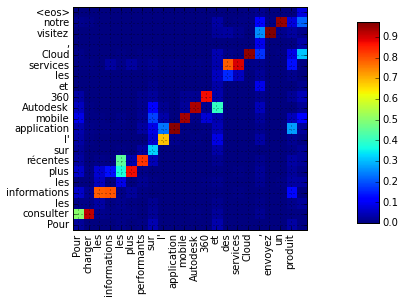

In [10]:
input="Pour consulter les informations les plus récentes sur l' application mobile Autodesk 360 et les services Cloud , visitez notre <eos>"
output="Pour charger les informations les plus performants sur l' application mobile Autodesk 360 et des services Cloud , envoyez un produit"
align=[[0.023974543437361717, 0.00010954080062219873, 0.0012802534038200974, 9.840877464739606e-05, 0.008929023519158363, 0.00020873236644547433, 0.004854063503444195, 0.04251604899764061, 0.00044299880391918123, 0.00042503367876634, 0.00013056027819402516, 0.0011591165093705058, 0.002505464246496558, 0.038309693336486816, 0.00020073135965503752, 0.0006160964840091765, 0.000812053622212261, 0.0034531529527157545, 0.0012626835377886891, 0.001184790744446218, 0.0312514528632164, 0.007608521729707718], [0.5049564242362976, 0.9188373684883118, 0.012905106879770756, 0.007807095069438219, 0.007885956205427647, 0.008870677091181278, 0.0031362883746623993, 0.019989492371678352, 0.0012361027766019106, 0.0010381521424278617, 0.00013900414342060685, 0.004459441173821688, 0.0011795380851253867, 0.023101817816495895, 0.001220707898028195, 0.0023735323920845985, 0.0003623377124313265, 0.016882603988051414, 0.00370777677744627, 0.0009212915319949389, 0.005642704665660858, 0.004299839958548546], [0.008406165987253189, 0.009247769601643085, 0.030759595334529877, 0.006647231988608837, 0.012927521020174026, 0.004636371973901987, 0.0020113750360906124, 0.015614861622452736, 0.0008544516167603433, 0.000891472736839205, 0.00023523361596744508, 0.002776108682155609, 0.0013613414485007524, 0.013543892651796341, 0.0003481307066977024, 0.0014003320829942822, 0.0005875648348592222, 0.008955190889537334, 0.0010226547019556165, 0.0022864113561809063, 0.01341204158961773, 0.022924531251192093], [0.06363987922668457, 0.017864838242530823, 0.7913151383399963, 0.7991980314254761, 0.009325030259788036, 0.025570914149284363, 0.006113954819738865, 0.0017005412373691797, 0.0008879749220795929, 0.0005739977350458503, 2.260089968331158e-05, 0.00019655008509289473, 0.001454630633816123, 0.004322877153754234, 0.0010741482255980372, 0.005788157228380442, 0.000635292090009898, 0.0068796128034591675, 0.0004987291758880019, 0.0010323782917112112, 0.12850601971149445, 0.0033022831194102764], [0.002560526132583618, 0.0007290553185157478, 0.05543442815542221, 0.0025591484736651182, 0.09001810848712921, 0.0036846580915153027, 0.017977900803089142, 0.006754620000720024, 0.0003699650405906141, 0.00017294321150984615, 0.00012106063513783738, 0.00129578891210258, 0.005352167412638664, 0.011729301884770393, 0.00022302368597593158, 0.0004719884891528636, 0.001963102724403143, 0.01648624986410141, 0.0004186169244349003, 0.0043430025689303875, 0.03310558944940567, 0.029209144413471222], [0.06204652413725853, 0.004181602504104376, 0.07172033935785294, 0.13547149300575256, 0.37318480014801025, 0.8728342056274414, 0.009792057797312737, 0.0021058162674307823, 0.00117843272164464, 0.0008585359901189804, 6.192094588186592e-05, 0.0001395612198393792, 0.0013049275148659945, 0.0041091893799602985, 0.0001974962797248736, 0.00543301273137331, 0.0012444322928786278, 0.022756017744541168, 0.0005187921924516559, 0.0011369251878932118, 0.024743540212512016, 0.007847234606742859], [0.02752191387116909, 0.0031729028560221195, 0.008912386372685432, 0.005900246556848288, 0.452003538608551, 0.04022593051195145, 0.8338170051574707, 0.04610377550125122, 0.00032066390849649906, 0.00027921880246140063, 0.0006502368487417698, 0.0003042799071408808, 0.001582390395924449, 0.018663017079234123, 0.00075766711961478, 0.0012245334219187498, 0.0009918642463162541, 0.013114222325384617, 0.0004157289513386786, 0.0014429859584197402, 0.03094562329351902, 0.019118865951895714], [0.019320311024785042, 0.000724435260053724, 0.0008953580399975181, 5.1686554797925055e-05, 0.004813008476048708, 0.0007032983703538775, 0.029914529994130135, 0.32273465394973755, 0.0005708847311325371, 0.0009932159446179867, 0.000538553693331778, 0.0014515828806906939, 0.0006498961593024433, 0.03518970310688019, 0.00019265359151177108, 0.00019736128160730004, 0.000281027372693643, 0.0030071893706917763, 0.0004010601551271975, 0.00038178369868546724, 0.00912817195057869, 0.02062002755701542], [0.032085977494716644, 0.004894447512924671, 0.0021890203934162855, 0.0008939366089180112, 0.0017844479298219085, 0.0011114416411146522, 0.0027394273784011602, 0.07216150313615799, 0.6858072280883789, 0.013304236344993114, 0.001975126564502716, 0.003865140490233898, 0.0020076504442840815, 0.08750951290130615, 0.0008784533711150289, 0.0019203734118491411, 0.0011505803558975458, 0.0311257466673851, 0.0002855522616300732, 0.0029445840045809746, 0.018352659419178963, 0.006144387181848288], [0.03877367824316025, 0.010595514439046383, 0.007579216733574867, 0.003934337757527828, 0.004074907395988703, 0.0024936613626778126, 0.027225973084568977, 0.0889296680688858, 0.23416230082511902, 0.9639220237731934, 0.005359511822462082, 0.0032397920731455088, 0.006359833292663097, 0.047516223043203354, 0.0013004335341975093, 0.0032458154018968344, 0.001149048563092947, 0.0148426853120327, 6.524482887471095e-05, 0.00318034621886909, 0.27116113901138306, 0.023440232500433922], [0.0886121317744255, 0.005895486567169428, 0.00697138300165534, 0.0006705845007672906, 0.011349020525813103, 0.0009473070385865867, 0.015748964622616768, 0.18607990443706512, 0.03477704897522926, 0.002804529620334506, 0.9432881474494934, 0.009188936091959476, 0.07279852777719498, 0.04146360233426094, 0.00033541052835062146, 0.0006045754416845739, 0.0007926427060738206, 0.025125587359070778, 0.0005435749772004783, 0.0015940016601234674, 0.051791660487651825, 0.10728015750646591], [0.05634308233857155, 0.004845935385674238, 0.0016058053588494658, 0.0004100811784155667, 0.0034775573294609785, 0.0012241073418408632, 0.014897886663675308, 0.12451320141553879, 0.017649834975600243, 0.0028667664155364037, 0.023681003600358963, 0.9354350566864014, 0.015867160633206367, 0.4017179012298584, 0.0002745585807133466, 0.001216853503137827, 0.002549487166106701, 0.04955599084496498, 0.001482224790379405, 8.774001616984606e-05, 0.0033504373859614134, 0.02250225655734539], [0.030718989670276642, 0.0009188276599161327, 0.0021384647116065025, 0.0013392370892688632, 0.0028575642500072718, 0.000194889769772999, 0.014088540337979794, 0.02339542657136917, 0.006333588622510433, 0.000572114484384656, 0.0164128877222538, 0.018764978274703026, 0.875568687915802, 0.03950877860188484, 0.00023171670909505337, 0.0005825501284562051, 0.0028160298243165016, 0.015482112765312195, 0.0024338443763554096, 0.0005149449571035802, 0.0213263388723135, 0.04774488881230354], [0.0017434400506317616, 0.00016056954336818308, 0.00026853493181988597, 0.00010655962250893936, 0.0007881748606450856, 0.00018609639664646238, 0.0005603783065453172, 0.014420371502637863, 0.0004437472380232066, 0.0001404128852300346, 6.65377447148785e-05, 0.0017104543512687087, 0.00035483093233779073, 0.03453955799341202, 0.0003166183305438608, 0.000642196333501488, 0.00028457658481784165, 0.09393094480037689, 0.0016254304209724069, 9.533375850878656e-05, 0.0026819121558219194, 0.013012432493269444], [0.00040552334394305944, 0.0005228266818448901, 0.0003669999714475125, 0.0011256532743573189, 0.0013255680678412318, 0.0029126927256584167, 0.0019079926423728466, 0.00677940808236599, 0.0018847741885110736, 0.00025134760653600097, 0.00010841905896086246, 0.001319064642302692, 0.0009058791329152882, 0.05479217320680618, 0.16307374835014343, 0.05444338172674179, 0.0015131797408685088, 0.019153734669089317, 0.0027222991921007633, 0.0012797284871339798, 0.012652089819312096, 0.003022414166480303], [0.004882941488176584, 0.004252515733242035, 0.0030825536232441664, 0.029489587992429733, 0.007684812415391207, 0.02995975874364376, 0.00933420192450285, 0.015898728743195534, 0.006819006521254778, 0.008815411478281021, 0.0028459972236305475, 0.010246824473142624, 0.007421612273901701, 0.039934489876031876, 0.7917761206626892, 0.8958959579467773, 0.011162996292114258, 0.01151032280176878, 0.0005161529406905174, 0.0007404903881251812, 0.13677842915058136, 0.004153580870479345], [0.011314122006297112, 0.0012218791525810957, 0.0009003663435578346, 0.0018660223577171564, 0.006148565094918013, 0.0017770970007404685, 0.004850828554481268, 0.004665430635213852, 0.0009829108603298664, 0.0010373712284490466, 0.003093133447691798, 0.0017893981421366334, 0.002409164560958743, 0.042553722858428955, 0.009145151823759079, 0.005217766854912043, 0.9591275453567505, 0.17094478011131287, 0.0003766400914173573, 0.004112860653549433, 0.08681928366422653, 0.3117053508758545], [0.0018331203609704971, 0.0002537016407586634, 7.374055712716654e-05, 8.922157576307654e-05, 6.980834587011486e-05, 0.00012298942601773888, 3.3427219022996724e-05, 0.0006593139260075986, 6.627239781664684e-05, 3.0009547117515467e-05, 1.94885469682049e-05, 4.9801536079030484e-05, 2.4063765522441827e-05, 0.0007988286670297384, 8.994718518806621e-05, 0.0003866154875140637, 0.0008364745299331844, 0.09504900872707367, 0.0008832227322272956, 0.0013399752788245678, 0.004517453722655773, 0.035429880023002625], [0.0036743944510817528, 0.0028935186564922333, 0.00023142558347899467, 0.0011088845785707235, 0.000671546789817512, 0.0013743648305535316, 0.0005468763993121684, 0.0026699285954236984, 0.0025678384117782116, 0.00040649311267770827, 0.0005384366377256811, 0.001552641042508185, 0.0005958143738098443, 0.025406111031770706, 0.026903588324785233, 0.013059272430837154, 0.0021509104408323765, 0.25589340925216675, 0.9751923084259033, 0.013946441002190113, 0.028300674632191658, 0.011582208797335625], [0.015215503983199596, 0.00842443946748972, 0.0010100457584485412, 0.001054422347806394, 0.0005058163078501821, 0.0007895467570051551, 0.00039260528865270317, 0.0015028321649879217, 0.0023890258744359016, 0.0005131707875989377, 0.000584425637498498, 0.0008748218533582985, 0.00019356065604370087, 0.03176536411046982, 0.001357045373879373, 0.005189777351915836, 0.004236417822539806, 0.11013366281986237, 0.005560999736189842, 0.9554645419120789, 0.08230198919773102, 0.21752013266086578], [0.0019707551691681147, 0.00025284659932367504, 0.0003598895273171365, 0.00017814312013797462, 0.00017523375572636724, 0.00017122075951192528, 5.574501119554043e-05, 0.0008044364512898028, 0.00025493442080914974, 0.00010355412086937577, 0.00012774107744917274, 0.0001806328509701416, 0.00010288364137522876, 0.003524261526763439, 0.00010263145668432117, 8.982253348222002e-05, 0.005352454259991646, 0.015717793256044388, 6.6467619035393e-05, 0.0019694240763783455, 0.003230767324566841, 0.08153163641691208]]
plotAlignmentMatrix(input,output,align)

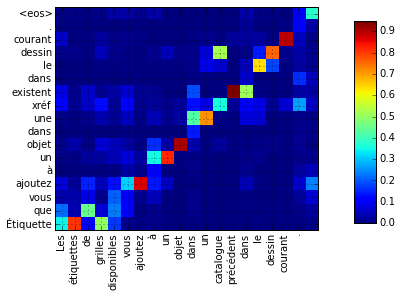

In [11]:
input="Étiquette que vous ajoutez à un objet dans une xréf existent dans le dessin courant . <eos>"
output="Les étiquettes de grilles disponibles vous ajoutez à un objet dans un catalogue précédent dans le dessin courant ."
align=[[0.3439205288887024, 0.808229923248291, 0.1210615262389183, 0.5023662447929382, 0.17358793318271637, 0.01400698721408844, 0.005830131005495787, 0.012107579037547112, 0.0006355163641273975, 0.00037915646680630744, 0.001321478863246739, 0.0007936545298434794, 0.0013379964511841536, 4.7586701839463785e-05, 0.001977202482521534, 0.003989169839769602, 0.001996185863390565, 0.00029451982118189335, 0.005701630376279354, 0.0104881776496768], [0.21900659799575806, 0.04148281738162041, 0.4522057771682739, 0.07029001414775848, 0.2358509600162506, 0.1217590719461441, 0.003404332557693124, 0.014019356109201908, 0.0004812741535715759, 0.0005802861414849758, 0.01195450033992529, 0.003425072878599167, 0.001845248625613749, 0.0008607660420238972, 0.006684835534542799, 0.0024272939190268517, 0.005796938203275204, 0.0014855663757771254, 0.013807364739477634, 0.02418902888894081], [0.03826095908880234, 0.035307954996824265, 0.08508734405040741, 0.011554206721484661, 0.20833979547023773, 0.10287196934223175, 0.014010187238454819, 0.05446867644786835, 0.0027086534537374973, 0.00023832867736928165, 0.01119654905050993, 0.0014105781447142363, 0.001072343555279076, 0.00014098532847128808, 0.005112661048769951, 0.0025350952055305243, 0.0010266550816595554, 0.0007126860436983407, 0.022742319852113724, 0.06860450655221939], [0.07707749307155609, 0.02077949047088623, 0.14871875941753387, 0.047108378261327744, 0.13230890035629272, 0.31333228945732117, 0.8719993233680725, 0.14032886922359467, 0.054132118821144104, 0.0028348274063318968, 0.003293597372248769, 0.0005983944283798337, 0.0021244273521006107, 0.00019045376393478364, 0.04622819647192955, 0.0042486730962991714, 0.0023725356440991163, 0.000312492367811501, 0.06886783242225647, 0.2401576191186905], [0.0009396217064931989, 0.0012886114418506622, 0.004003012552857399, 0.0017041171668097377, 0.005451950244605541, 0.03513774648308754, 0.012872886843979359, 0.10571028292179108, 0.0013319565914571285, 0.00029689009534195065, 0.01008532103151083, 0.0004228627949487418, 0.0005625517223961651, 0.00012110285024391487, 0.01795056089758873, 0.00196722405962646, 0.0002787616103887558, 0.0006864758906885982, 0.03201216086745262, 0.049734581261873245], [0.008577987551689148, 0.004927209112793207, 0.028253717347979546, 0.029433317482471466, 0.04842569679021835, 0.07978847622871399, 0.028676258400082588, 0.35346531867980957, 0.8229627013206482, 0.004734732676297426, 0.006001603323966265, 0.003058584174141288, 0.0008645488414913416, 0.0002694587456062436, 0.008058454841375351, 0.013309743255376816, 0.0011817956110462546, 0.0010254128137603402, 0.007515615317970514, 0.013043477199971676], [0.014814989641308784, 0.036565396934747696, 0.006817772053182125, 0.06849830597639084, 0.0525396354496479, 0.03118029423058033, 0.004747685510665178, 0.15944607555866241, 0.0328400544822216, 0.9089703559875488, 0.03736887872219086, 0.004381558392196894, 0.026073114946484566, 0.00027359038358554244, 0.00593887222930789, 0.004199410788714886, 0.008681089617311954, 0.000986491097137332, 0.021080438047647476, 0.0026371965650469065], [0.0014926379080861807, 0.0011003646068274975, 0.00109544035512954, 0.00370738934725523, 0.002089056419208646, 0.0065565211698412895, 0.0003876195114571601, 0.0021889887284487486, 0.00015596352750435472, 0.00031195342307910323, 0.14067941904067993, 0.000406480161473155, 9.37942968448624e-05, 0.0002547313633840531, 0.0032712072134017944, 0.000466421915916726, 0.00025229688617400825, 0.0003232117451261729, 0.015845688059926033, 0.007525660563260317], [0.008455095812678337, 0.0019652857445180416, 0.012071588076651096, 0.03753547742962837, 0.018526369705796242, 0.05867043882608414, 0.003859174670651555, 0.050627466291189194, 0.012413217686116695, 0.03080713003873825, 0.4227353632450104, 0.7153390049934387, 0.008418411016464233, 0.0008624636684544384, 0.08129744231700897, 0.06763152033090591, 0.0030867564491927624, 0.002850863616913557, 0.011241333559155464, 0.004218687303364277], [0.10656014829874039, 0.016611261293292046, 0.06233546882867813, 0.12799975275993347, 0.024826819077134132, 0.10766803473234177, 0.01151464506983757, 0.02533232793211937, 0.009711816906929016, 0.029121020808815956, 0.13268160820007324, 0.08712011575698853, 0.35779815912246704, 0.02018410712480545, 0.10345035791397095, 0.08147671818733215, 0.018675964325666428, 0.0716402679681778, 0.26676079630851746, 0.05587765946984291], [0.08816985040903091, 0.011171125806868076, 0.059445079416036606, 0.01597730442881584, 0.033750981092453, 0.07006426155567169, 0.017348283901810646, 0.01769282855093479, 0.002327108755707741, 0.0005547171458601952, 0.1913272887468338, 0.0021489188075065613, 0.004420640878379345, 0.9460480809211731, 0.5111639499664307, 0.005281451158225536, 0.002283708890900016, 0.0006343882996588945, 0.03582457825541496, 0.032591503113508224], [0.001291814842261374, 0.0005734982551075518, 0.0007112887687981129, 0.0005541271530091763, 0.001662899972870946, 0.001410296536050737, 0.0017271842807531357, 0.0005903247511014342, 0.000193192798178643, 5.7234999985666946e-05, 0.004766395315527916, 0.00013601065438706428, 0.0002652492839843035, 0.0014684410998597741, 0.06430041044950485, 0.000940173224080354, 6.997070886427537e-05, 8.845880802255124e-05, 0.15939833223819733, 0.049911122769117355], [0.0029040758963674307, 0.0022036810405552387, 0.000511055754031986, 0.004281478933990002, 0.005862212274223566, 0.0057464116252958775, 0.0022673008497804403, 0.004704220220446587, 0.0065713184885680676, 0.003803880652412772, 0.008224619552493095, 0.09095902740955353, 0.06673348695039749, 0.0010330532677471638, 0.04735986515879631, 0.6365624070167542, 0.18364208936691284, 0.006161196622997522, 0.030665596947073936, 0.012333721853792667], [0.01260472647845745, 0.00868702307343483, 0.0046486444771289825, 0.04954914748668671, 0.011442876420915127, 0.0059596095234155655, 0.0020136754028499126, 0.01766827702522278, 0.048843979835510254, 0.013583638705313206, 0.008348348550498486, 0.0775492936372757, 0.5219125151634216, 0.002027666661888361, 0.010827487334609032, 0.14095446467399597, 0.758967399597168, 0.011744499206542969, 0.03528888523578644, 0.01236527319997549], [0.06219879910349846, 0.0032975617796182632, 0.006691367365419865, 0.024101391434669495, 0.010446716099977493, 0.014054274186491966, 0.004891787189990282, 0.0022999944631010294, 0.001834111288189888, 0.0031614291947335005, 0.006302331108599901, 0.011988061480224133, 0.005180337466299534, 0.02546158991754055, 0.027468061074614525, 0.02848125249147415, 0.0074193826876580715, 0.8959689736366272, 0.055320389568805695, 0.007248850539326668], [0.004883517976850271, 0.0005194463883526623, 0.00037250580498948693, 0.00137642293702811, 0.00013438599125947803, 0.0015502095920965075, 0.0008279221947304904, 0.0010555991902947426, 0.0001142300243373029, 0.000249644392170012, 0.0005736589664593339, 8.688981324667111e-05, 0.00020950833277311176, 0.00024800936807878315, 0.018763002008199692, 0.0012171631678938866, 4.7564673877786845e-05, 0.003890783293172717, 0.11844393610954285, 0.029890021309256554], [0.008841188624501228, 0.0052893562242388725, 0.005969666410237551, 0.003962954506278038, 0.03475281596183777, 0.030243122950196266, 0.013621578924357891, 0.03829381614923477, 0.0027427603490650654, 0.0003148051328025758, 0.003138974541798234, 0.00017548543110024184, 0.0010876102605834603, 0.0005079299444332719, 0.040147438645362854, 0.004311836324632168, 0.004220951348543167, 0.001193745294585824, 0.09948311001062393, 0.379182904958725]]
plotAlignmentMatrix(input,output,align)